In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer,MissingIndicator, KNNImputer
from sklearn.model_selection import train_test_split, cross_validate,GridSearchCV,RepeatedStratifiedKFold,cross_val_score,cross_val_predict
from sklearn.preprocessing import PowerTransformer,OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer,make_column_selector,ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score
from sklearn.impute import  KNNImputer
from sklearn.svm import SVC
from lightgbm import LGBMRegressor, LGBMClassifier
import xgboost as xgb

import warnings; warnings.filterwarnings("ignore")

#from kuma_utils.preprocessing.imputer import LGBMImputer 
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import PolynomialFeatures
from geopy.distance import geodesic

import gc

from category_encoders import OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import KBinsDiscretizer,LabelEncoder
from feature_engine.encoding import OrdinalEncoder
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import RareLabelEncoder
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures
from feature_engine.selection import (RecursiveFeatureElimination, RecursiveFeatureAddition,
    DropConstantFeatures,
    DropDuplicateFeatures,
    SmartCorrelatedSelection,DropCorrelatedFeatures
)
from feature_engine.creation import MathFeatures,RelativeFeatures

# to select the features
from sklearn.feature_selection import SelectKBest, SelectPercentile
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder
from sklearn import metrics
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.cluster import KMeans
from category_encoders import MEstimateEncoder,OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import KBinsDiscretizer


from sklearn.ensemble import StackingRegressor

In [3]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor ,AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet, LassoLars, PassiveAggressiveRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, metrics, Pool, cv
pd.set_option('display.max_columns', None)

In [4]:
# DATA LOADING
train = pd.read_csv("./food-delivery-dataset/train.csv")
test = pd.read_csv("./food-delivery-dataset/test.csv")

In [5]:
# DATA CLEANING

#test=test.replace(" ","")
test=test.replace('NaN', float(np.nan), regex=True)

#train=train.replace(" ","")
train=train.replace('NaN', float(np.nan), regex=True)

In [6]:
train['Weatherconditions']=train['Weatherconditions'].str.split(" ", expand=True)[1]
test['Weatherconditions']=test['Weatherconditions'].str.split(" ", expand=True)[1]

train['Time_taken(min)']=train['Time_taken(min)'].str.split(" ", expand=True)[1]

In [7]:
num_cols = ['Delivery_person_Age','Delivery_person_Ratings','Restaurant_latitude','Restaurant_longitude',
            'Delivery_location_latitude','Delivery_location_longitude','Vehicle_condition',
            'multiple_deliveries','Time_taken(min)']
for col in num_cols:
    train[col]=train[col].astype('float64')
    
for col in num_cols[:-1]:
    test[col]=test[col].astype('float64')
    
train['Order_Date']=pd.to_datetime(train['Order_Date'],format="%d-%m-%Y")
test['Order_Date']=pd.to_datetime(test['Order_Date'],format="%d-%m-%Y")

In [8]:
train['Time_Orderd']=pd.to_timedelta(train['Time_Orderd'])
train['Time_Order_picked']=pd.to_timedelta(train['Time_Order_picked'])

train['Time_Order_picked_formatted']=np.where(train['Time_Order_picked'] < train['Time_Orderd'], train['Order_Date'] + pd.DateOffset(1)+train['Time_Order_picked'], train['Order_Date']+train['Time_Order_picked'])
train['Time_Ordered_formatted'] = train['Order_Date']+ train['Time_Orderd']
train['order_prepare_time_diff_mins']=((train['Time_Order_picked_formatted']- train['Time_Ordered_formatted']).dt.total_seconds())/60

In [9]:
test['Time_Orderd']=pd.to_timedelta(test['Time_Orderd'])
test['Time_Order_picked']=pd.to_timedelta(test['Time_Order_picked'])

test['Time_Order_picked_formatted']=np.where(test['Time_Order_picked'] < test['Time_Orderd'], test['Order_Date'] + pd.DateOffset(1)+test['Time_Order_picked'], test['Order_Date']+test['Time_Order_picked'])
test['Time_Ordered_formatted'] = test['Order_Date']+ test['Time_Orderd']
test['order_prepare_time_diff_mins']=((test['Time_Order_picked_formatted']- test['Time_Ordered_formatted']).dt.total_seconds())/60

In [10]:
cols=['Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude']
for col in cols:
    train[col]= abs(train[col])
for col in cols:
    test[col]= abs(test[col])

In [11]:
# Creating new features on the basis of latitude and longitude
train['distance_diff_KM']=np.zeros(len(train))
restaurant_cordinates_train=train[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
delivery_location_cordinates_train=train[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()

for i in range(len(train)):
    train['distance_diff_KM'].loc[i]=geodesic(restaurant_cordinates_train[i],delivery_location_cordinates_train[i])

In [12]:
test['distance_diff_KM']=np.zeros(len(test))
restaurant_cordinates_test=test[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
delivery_location_cordinates_test=test[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()

for i in range(len(test)):
    test['distance_diff_KM'].loc[i]=geodesic(restaurant_cordinates_test[i],delivery_location_cordinates_test[i])

In [13]:
y=train["Time_taken(min)"]
train = train.drop(columns=["Time_taken(min)",'ID'],axis=1)
Id= test['ID'].str.strip()
test = test.drop(columns=["ID"],axis=1)

In [14]:
data=pd.concat([train,test]).reset_index(drop=True)

In [15]:
data.head()

,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_Order_picked_formatted,Time_Ordered_formatted,order_prepare_time_diff_mins,distance_diff_KM
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,0 days 11:30:00,0 days 11:45:00,Sunny,High,2.0,Snack,motorcycle,0.0,No,Urban,2022-03-19 11:45:00,2022-03-19 11:30:00,15.0,3.0207366434610656 km
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,0 days 19:45:00,0 days 19:50:00,Stormy,Jam,2.0,Snack,scooter,1.0,No,Metropolitian,2022-03-25 19:50:00,2022-03-25 19:45:00,5.0,20.143736910348597 km
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,0 days 08:30:00,0 days 08:45:00,Sandstorms,Low,0.0,Drinks,motorcycle,1.0,No,Urban,2022-03-19 08:45:00,2022-03-19 08:30:00,15.0,1.549692932239406 km
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,0 days 18:00:00,0 days 18:10:00,Sunny,Medium,0.0,Buffet,motorcycle,1.0,No,Metropolitian,2022-04-05 18:10:00,2022-04-05 18:00:00,10.0,7.774496620087613 km
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,0 days 13:30:00,0 days 13:45:00,Cloudy,High,1.0,Snack,scooter,1.0,No,Metropolitian,2022-03-26 13:45:00,2022-03-26 13:30:00,15.0,6.197897916874956 km


In [16]:
na_cols=[]
for col in data.columns:
    if data[col].isna().sum()>0:
        na_cols.append(col)

data["n_missing"]= data[na_cols].isna().sum(axis=1)
data_missing_tag_df = data[na_cols].isna().astype(np.int8)
data_missing_tag_df.columns = [f"{c}_missing" for c in data_missing_tag_df.columns]

data=pd.concat([data, data_missing_tag_df], axis=1)

In [17]:
# Creating time based features
data["day"] = data.Order_Date.dt.day
data["week"] = data.Order_Date.dt.isocalendar().week
data["month"] = data.Order_Date.dt.month
data["quarter"] = data.Order_Date.dt.quarter
data["year"] = data.Order_Date.dt.year
data["hour"] = data.Time_Orderd.dt.components['hours']
data["dayofyear"] = data.Order_Date.dt.dayofyear
data['day_of_week'] = data.Order_Date.dt.day_of_week.astype(int)
data["is_month_start"] = data.Order_Date.dt.is_month_start.astype(int)
data["is_month_end"] = data.Order_Date.dt.is_month_end.astype(int)
data["is_quarter_start"] = data.Order_Date.dt.is_quarter_start.astype(int)
data["is_quarter_end"] = data.Order_Date.dt.is_quarter_end.astype(int)
data["is_year_start"] = data.Order_Date.dt.is_year_start.astype(int)
data["is_year_end"] = data.Order_Date.dt.is_year_end.astype(int)
data["is_leap_year"] = data.Order_Date.dt.is_leap_year.astype(int)
data["days_in_month"] = data.Order_Date.dt.days_in_month
data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]),1,0)

In [18]:
data['distance_diff_KM']=data['distance_diff_KM'].astype("str").str.extract('(\d+)')
data['distance_diff_KM']=data['distance_diff_KM'].astype("int64")

In [19]:
data=data.drop(columns=['Order_Date','Time_Orderd','Time_Order_picked'],axis=1)
data=data.drop(columns=['Time_Order_picked_formatted','Time_Ordered_formatted'])

In [20]:
data['week']=data['week'].astype("int64")

In [21]:
for col in data.columns:
    if data[col].dtype == 'uint8':
        data[col]=data[col].astype("int64")

In [22]:
data['city_code']=data['Delivery_person_ID'].str.split("RES", expand=True)[0]

In [23]:
data=data.drop(columns=["Delivery_person_ID" ],  axis=1)

In [24]:
# Removing constant and duplicate features
pipe = Pipeline([
   ('constant', DropConstantFeatures(tol=0.998,missing_values='ignore')),
   ('duplicated', DropDuplicateFeatures(missing_values='ignore')),                         
])
data=pipe.fit_transform(data)

In [25]:
# More Feature Engineering
num_ft = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
mf=MathFeatures(['Delivery_person_Age','Delivery_person_Ratings'],missing_values='ignore',func= ["std",'mean'])
data=mf.fit_transform(data)

In [26]:
feat1=data.groupby("Delivery_person_Age")["Delivery_person_Ratings"].transform("mean")
data['feat2']=data['Delivery_person_Ratings'] - feat1

feat3=data.groupby("Delivery_person_Age")["Delivery_person_Ratings"].transform("std")
data['feat4']=data['Delivery_person_Ratings'] - feat3

data['feat9']=data.groupby(["Weatherconditions",'Road_traffic_density'])["Delivery_person_Age"].transform("mean")
#data['feat10']=data['Delivery_person_Age'] - data['feat9']

feat11=data.groupby(["Weatherconditions",'Road_traffic_density'])["Delivery_person_Age"].transform("std")
data['feat12']=data['Delivery_person_Age'] - feat11

data['feat13']=data.groupby(["Weatherconditions",'Road_traffic_density','City','city_code'])["distance_diff_KM"].transform("std")
data['feat14']=data['Delivery_person_Age'] - data['feat13']

In [27]:
# Target encoding
encoder = MEstimateEncoder(m=1)

train= data[:len(train)]
test=data[len(train):]

train =  encoder.fit_transform(train,y)
test= encoder.transform(test)

In [28]:
xgb_model=xgb.XGBRegressor(n_estimators=25,max_depth=7)
lgb = LGBMRegressor(num_leaves=85,max_depth=8,learning_rate=0.1)
cat= CatBoostRegressor(n_estimators=700,max_depth=8,learning_rate=0.05)

In [29]:
# Feature Selection
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# sfs = SFS(LGBMRegressor(num_leaves=85,max_depth=8,learning_rate=0.1), 
#            k_features=20, 
#            forward=True, 
#            floating=False, 
#            verbose=2,
#            scoring='r2',
#            cv=2)

# sfs = sfs.fit(train ,y)
# selected_feat_= list(sfs.k_feature_names_)

# selected_feat_

In [30]:
selected_feat_=['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Weatherconditions',
 'Road_traffic_density',
 'Vehicle_condition',
 'multiple_deliveries',
 'Festival',
 'City',
 'distance_diff_KM',
 'n_missing',
 'Weatherconditions_missing',
 'multiple_deliveries_missing',
 'Festival_missing',
 'City_missing',
 'is_month_end',
 'is_quarter_start',
 'is_weekend',
 'feat2',
 'feat9',
 'feat12']

In [31]:
imp_feat=selected_feat_[:12]

In [39]:
# Stacking
#best_1

estimators = [
     ('xgb_model', xgb_model),
     ('lgb', lgb),('cat',cat)]
# best
model = StackingRegressor(
estimators=estimators,
 final_estimator=xgb_model)

xgb = xgb_model.fit(train[imp_feat],y)
reg = reg.fit(train,y)
lgb = lgb.fit(train[imp_feat],y)
cat = cat.fit(train[imp_feat],y)

reg_pred=reg.predict(test)
lgb_pred=lgb.predict(test[imp_feat])
cat_pred=cat.predict(test[imp_feat])
xgb_pred=xgb_model.predict(test[imp_feat])

ensemble=reg_pred*0.2 + lgb_pred*0.45 + cat_pred*0.35  # Using these ratios after lots of experimenting

0:	learn: 9.0294834	total: 38.7ms	remaining: 27s
1:	learn: 8.6952508	total: 70.5ms	remaining: 24.6s
2:	learn: 8.3602180	total: 111ms	remaining: 25.7s
3:	learn: 8.0666730	total: 137ms	remaining: 23.9s
4:	learn: 7.7683223	total: 176ms	remaining: 24.5s
5:	learn: 7.5090658	total: 214ms	remaining: 24.7s
6:	learn: 7.2445646	total: 248ms	remaining: 24.6s
7:	learn: 7.0204333	total: 304ms	remaining: 26.3s
8:	learn: 6.8077370	total: 353ms	remaining: 27.1s
9:	learn: 6.6081442	total: 404ms	remaining: 27.9s
10:	learn: 6.4250621	total: 449ms	remaining: 28.1s
11:	learn: 6.2309588	total: 491ms	remaining: 28.1s
12:	learn: 6.0673957	total: 528ms	remaining: 27.9s
13:	learn: 5.9149389	total: 570ms	remaining: 28s
14:	learn: 5.7728985	total: 605ms	remaining: 27.6s
15:	learn: 5.6515749	total: 631ms	remaining: 27s
16:	learn: 5.5168847	total: 667ms	remaining: 26.8s
17:	learn: 5.4151680	total: 716ms	remaining: 27.1s
18:	learn: 5.3014673	total: 772ms	remaining: 27.7s
19:	learn: 5.2029740	total: 835ms	remaining: 

Finally I encourage my fellow Kagglers to use this data in order to improve their ML skills such as

- create features on the basis of location, use different types of aggreation techinique.
- use different techinque to fill na values
- try to use different transformations
- try different feature selection techniques
- try different encoding techinqiue such as ordinal encoding etc.
- try different alogirithims

In [44]:
import lime
import lime.lime_tabular

In [47]:
train

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,order_prepare_time_diff_mins,distance_diff_KM,n_missing,Delivery_person_Age_missing,Delivery_person_Ratings_missing,Time_Orderd_missing,Weatherconditions_missing,Road_traffic_density_missing,multiple_deliveries_missing,Festival_missing,City_missing,day,week,month,quarter,hour,dayofyear,day_of_week,is_month_start,is_month_end,is_quarter_start,days_in_month,is_weekend,city_code,std_Delivery_person_Age_Delivery_person_Ratings,mean_Delivery_person_Age_Delivery_person_Ratings,feat2,feat4,feat9,feat12,feat13,feat14
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,21.857556,27.239786,2.0,26.286310,27.605625,0.0,25.98485,22.984344,15.0,3,0,0,0,0,0,0,0,0,0,19,11,3,1,11.0,78,5,0,0,0,31,1,26.116232,22.698128,20.95,0.296175,4.566417,29.625139,31.161159,2.114377,34.885623
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,25.870871,31.176279,2.0,26.286310,24.480873,1.0,25.98485,27.315196,5.0,20,0,0,0,0,0,0,0,0,0,25,12,3,1,19.0,84,4,0,0,0,31,0,26.052971,20.859650,19.25,-0.087090,4.151610,29.562094,28.182571,4.826762,29.173238
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,25.875573,21.267302,0.0,26.187962,27.605625,1.0,25.98485,22.984344,15.0,1,0,0,0,0,0,0,0,0,0,19,11,3,1,8.0,78,5,0,0,0,31,1,26.052971,13.152186,13.70,-0.284190,4.116032,29.416640,17.338625,6.282038,16.717962
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,21.857556,26.699607,0.0,26.283512,27.605625,1.0,25.98485,27.315196,10.0,7,0,0,0,0,0,0,0,0,0,5,14,4,2,18.0,95,1,0,0,0,30,0,26.292430,23.546656,21.35,0.102568,4.373598,29.486633,32.229402,5.194998,32.805002
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,28.916982,27.239786,1.0,26.286310,24.480873,1.0,25.98485,27.315196,15.0,6,0,0,0,0,0,0,0,0,0,26,12,3,1,13.0,85,5,0,0,0,31,1,26.358962,19.374726,18.30,0.016758,4.262937,29.599775,26.220285,2.078503,29.921497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45588,30.0,4.8,26.902328,75.794257,26.912328,75.804257,26.118860,27.239786,1.0,26.419259,27.605625,0.0,25.98485,27.315196,10.0,1,0,0,0,0,0,0,0,0,0,24,12,3,1,11.0,83,3,0,0,0,31,0,26.692014,17.819091,17.40,0.204034,4.472911,29.500000,24.227511,1.803467,28.196533
45589,21.0,4.6,0.000000,0.000000,0.070000,0.070000,26.118860,31.176279,0.0,26.283512,27.605625,1.0,25.98485,27.315196,15.0,10,0,0,0,0,0,0,0,0,0,16,7,2,1,19.0,47,2,0,0,0,28,0,26.643056,11.596551,12.80,-0.078815,4.305536,29.344912,15.227735,5.433455,15.566545
45590,30.0,4.9,13.022394,80.242439,13.052394,80.272439,28.916982,21.267302,1.0,26.187962,24.480873,0.0,25.98485,27.315196,15.0,4,0,0,0,0,0,0,0,0,0,11,10,3,1,23.0,70,4,0,0,0,31,0,26.358962,17.748380,17.45,0.304034,4.572911,29.520952,24.233447,6.119248,23.880752
45591,20.0,4.7,11.001753,76.986241,11.041753,77.026241,28.916982,27.239786,0.0,26.286310,27.605625,1.0,25.98485,27.315196,5.0,6,0,0,0,0,0,0,0,0,0,7,10,3,1,13.0,66,0,0,0,0,31,0,26.292430,10.818734,12.35,0.018040,4.403773,29.599775,14.220285,1.831808,18.168192


In [55]:
categorical_names_ = train[['Vehicle_condition','Type_of_order','Type_of_vehicle','Festival','City']]

In [68]:
imp_feat

['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Weatherconditions',
 'Road_traffic_density',
 'Vehicle_condition',
 'multiple_deliveries',
 'Festival',
 'City',
 'distance_diff_KM',
 'n_missing',
 'Weatherconditions_missing',
 'multiple_deliveries_missing']

In [66]:
explainer = lime.lime_tabular.LimeTabularExplainer(train[imp_feat],
                                                   feature_names = train.columns,
                                                   class_names=['not_survived','survived'],
                                                   categorical_features=selected_feat_,
                                                   categorical_names=categorical_names,
                                                   discretizer='decile',
                                                   kernel_width=5,discretize_continuous=True,verbose=True)

NameError: name 'categorical_names' is not defined

In [38]:
np.random.seed(1)
i = 1653
exp = explainer.explain_instance(test[i], predict_fn, num_features=5)
exp.show_in_notebook(show_all=False)

AttributeError: 'XGBRegressor' object has no attribute 'predict_proba'

In [ ]:
i = 10
exp = explainer.explain_instance(test[i], predict_fn, num_features=5)
exp.show_in_notebook(show_all=False)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


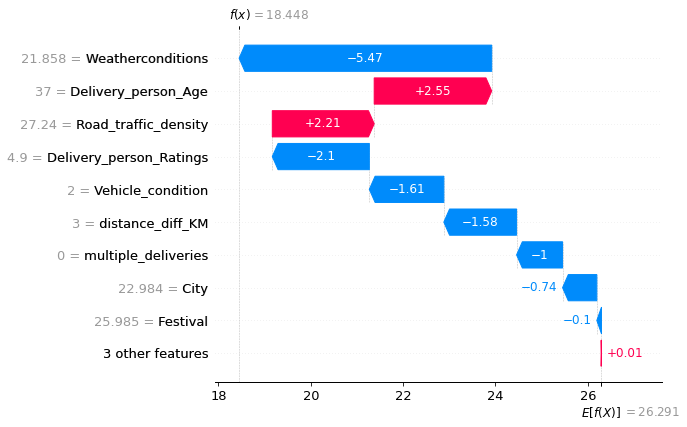

In [33]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(train[imp_feat])

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [58]:
shap.plots.force(shap_values[0])

In [ ]:
shap.plots.force(shap_values)

In [ ]:
shap.plots.scatter(shap_values[:,"RM"], color=shap_values)

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.plots.bar(shap_values)